# Superconduct dataset - linear regression

The objective value and the all gradient descents are saved in a pickle file. Thus, it is possible to play with results without need to recompute everything (it takes several hours). 
However, the transformed data is not saved because it can be generated without random. Thus to regenerate figures, be sure to intialy run the first cells of the notebook (those devoted to data preparation).

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from sklearn.preprocessing import scale

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import LogisticModel, RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, FL_VanillaSGD
from src.machinery.GradientUpdateMethod import ArtemisUpdate
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataClustering import *
from src.utils.DataPreparation import build_data_logistic, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "superconduct"

nb_devices_for_the_run = 20

In [2]:
import pandas as pd
data = pd.read_csv('../dataset/superconduct/train.csv', sep=",")
data.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
print(data.columns.values)

['number_of_elements' 'mean_atomic_mass' 'wtd_mean_atomic_mass'
 'gmean_atomic_mass' 'wtd_gmean_atomic_mass' 'entropy_atomic_mass'
 'wtd_entropy_atomic_mass' 'range_atomic_mass' 'wtd_range_atomic_mass'
 'std_atomic_mass' 'wtd_std_atomic_mass' 'mean_fie' 'wtd_mean_fie'
 'gmean_fie' 'wtd_gmean_fie' 'entropy_fie' 'wtd_entropy_fie' 'range_fie'
 'wtd_range_fie' 'std_fie' 'wtd_std_fie' 'mean_atomic_radius'
 'wtd_mean_atomic_radius' 'gmean_atomic_radius' 'wtd_gmean_atomic_radius'
 'entropy_atomic_radius' 'wtd_entropy_atomic_radius' 'range_atomic_radius'
 'wtd_range_atomic_radius' 'std_atomic_radius' 'wtd_std_atomic_radius'
 'mean_Density' 'wtd_mean_Density' 'gmean_Density' 'wtd_gmean_Density'
 'entropy_Density' 'wtd_entropy_Density' 'range_Density'
 'wtd_range_Density' 'std_Density' 'wtd_std_Density'
 'mean_ElectronAffinity' 'wtd_mean_ElectronAffinity'
 'gmean_ElectronAffinity' 'wtd_gmean_ElectronAffinity'
 'entropy_ElectronAffinity' 'wtd_entropy_ElectronAffinity'
 'range_ElectronAffinity' 'w

In [4]:
with pd.option_context('display.max_columns', 80):
    print(data.describe(include='all'))

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
count        21263.000000      21263.000000          21263.000000   
mean             4.115224         87.557631             72.988310   
std              1.439295         29.676497             33.490406   
min              1.000000          6.941000              6.423452   
25%              3.000000         72.458076             52.143839   
50%              4.000000         84.922750             60.696571   
75%              5.000000        100.404410             86.103540   
max              9.000000        208.980400            208.980400   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
count       21263.000000           21263.000000         21263.000000   
mean           71.290627              58.539916             1.165608   
std            31.030272              36.651067             0.364930   
min             5.320573               1.960849             0.000000   
25%            58.

In [5]:
dim_notebook = len(data.columns) - 1
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


In [6]:
if data.isnull().values.any():
    print("There is missing value.")
else:
    print("No missing value. Great !")

No missing value. Great !


In [7]:
X_data = data.loc[:, data.columns != "critical_temp"]
Y_data = data.loc[:, data.columns == "critical_temp"]
dim_notebook = len(X_data.columns)
print("There is " + str(dim_notebook) + " dimensions.")

There is 81 dimensions.


# IID data

In [8]:
def superconduct_step_size(it, L, omega, N): return 1 / (8 * L)

In [9]:
#Data normalisation
X_data = scale(X_data)
Y_data = scale(Y_data)

In [10]:
X_merged = torch.tensor(X_data, dtype=torch.float64)
Y_merged = torch.tensor(Y_data, dtype=torch.float64)
number_of_items = len(X_merged)
number_of_items_by_devices = number_of_items // nb_devices_for_the_run
print("Number of points by devices: ", number_of_items_by_devices)

X, Y = [], []
for i in range(nb_devices_for_the_run):
    X.append(X_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)])
    Y_temp = Y_merged[number_of_items_by_devices * i:number_of_items_by_devices * (i+1)]
    Y.append(torch.stack([y[0] for y in Y_temp]))
print("There is " + str(len(X)) + " devices.")


# Adding a columns of "1" to take into account a potential bias.
X = add_bias_term(X)
print(X[0].shape)

Number of points by devices:  1063
There is 20 devices.
torch.Size([1063, 82])


In [11]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [12]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min, filename + "-obj_min")

   it    |   obj   
     100 | 3.3845e-01
     200 | 3.1694e-01
     300 | 3.0779e-01
     400 | 3.0294e-01
Gradient Descent: execution time=16.602 seconds
Final loss : 0.29990

CPU times: user 2min 3s, sys: 16.1 s, total: 2min 19s
Wall time: 16.6 s


Text(0.5, 0, 'true value (normalized)')

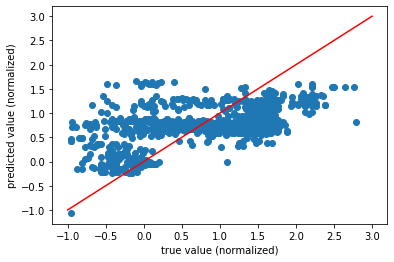

In [13]:
plt.scatter(Y[0], X[0].mv(obj_min_by_N_descent.model_params[-1]))
plt.plot(np.linspace(-1, 3, 2), np.linspace(-1, 3, 2), color='r')
plt.ylabel("predicted value (normalized)")
plt.xlabel("true value (normalized)")

In [14]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models = cost_models, 
                                               step_formula=superconduct_step_size,
                                               use_averaging=True, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

100%|██████████| 5/5 [4:28:59<00:00, 3227.88s/it]

CPU times: user 5h 29min 18s, sys: 5min 2s, total: 5h 34min 20s
Wall time: 4h 28min 59s


In [15]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.0047, -0.1738,  0.2439, -0.0989, -0.0201, -0.0645, -0.3583,  0.1458,
         0.3182, -0.0007, -0.1232, -0.1488,  0.0329,  0.0610, -0.0095, -0.0079,
         0.0864,  0.2032,  0.5109,  0.0965, -0.3618, -0.1543,  0.2042,  0.4608,
        -0.3643, -0.2501, -0.0008,  0.2612,  0.4471, -0.1021, -0.5598,  0.3038,
        -0.2383, -0.0474,  0.0082,  0.2172,  0.1730, -0.2076, -0.1527,  0.0148,
         0.2164, -0.0683, -0.0028,  0.3884,  0.0635, -0.4235,  0.0310, -0.1919,
        -0.5692, -0.1465,  0.6758, -0.2554,  0.1222, -0.1167, -0.0801,  0.0415,
        -0.1098,  0.2406, -0.2156,  0.1323,  0.1082, -0.0528, -0.0089,  0.5436,
        -0.1140, -0.2593,  0.0279,  0.0836, -0.2453, -0.2356,  0.1436,  0.2052,
        -0.0253, -0.0056,  0.0852, -0.0756,  0.2167, -0.3261,  0.1697,  0.0723,
        -0.0364, -0.2387], dtype=torch.float64)


## Without averaging

../src/utils/runner/ResultsOfSeveralDescents.py:47: RuntimeWarning: invalid value encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]
../src/utils/runner/ResultsOfSeveralDescents.py:68: RuntimeWarning: invalid value encountered in log10
  log_losses = [np.log10(loss - obj) for loss in losses]


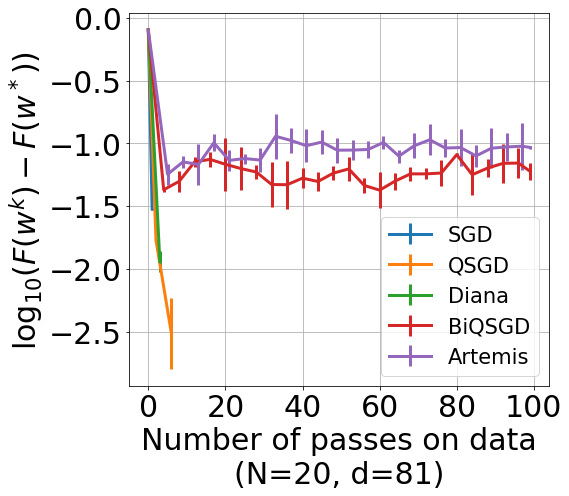

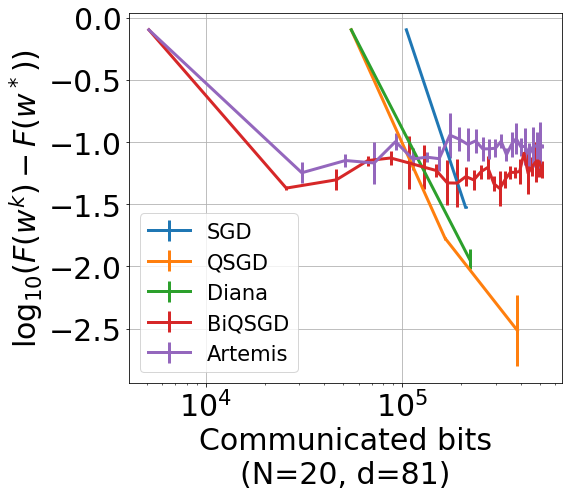

In [16]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj)) 

## With averaging

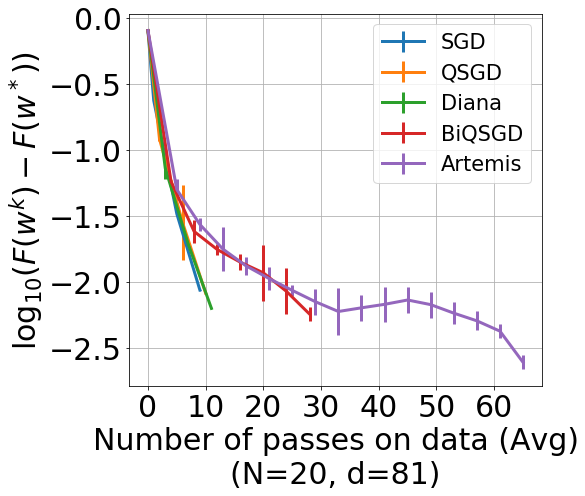

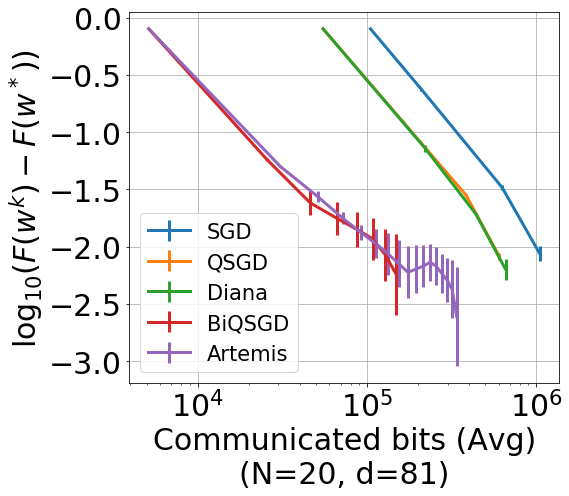

In [17]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), x_legend="Number of passes on data (Avg)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), x_legend="Communicated bits (Avg)") 


# Handling non-iid data

CPU times: user 21min 17s, sys: 1min 7s, total: 22min 25s
Wall time: 2min 23s


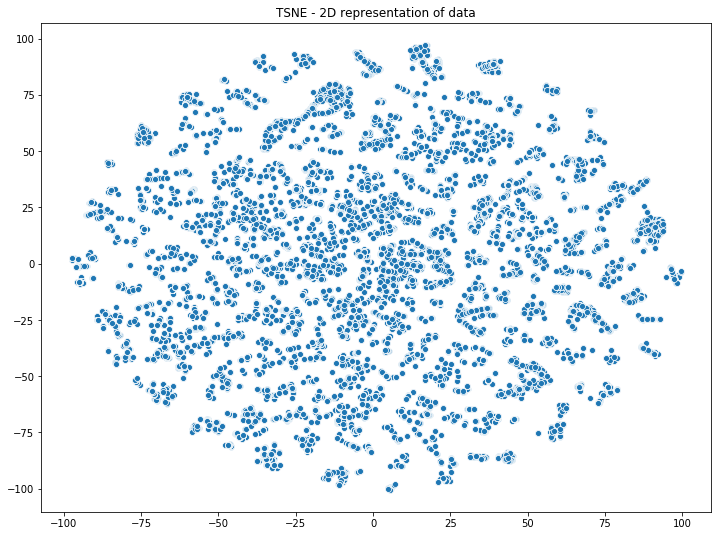

In [18]:
%%time
# Running TNSE to obtain a 2D representation of data
embedded_data = tsne(data)
pickle_saver(embedded_data, "{0}-tsne".format(filename))

superconduct-tsne
There is 20 devices.
Number of points on device 0 : 132
Number of points on device 1 : 1624
Number of points on device 2 : 716
Number of points on device 3 : 381
Number of points on device 4 : 380
Number of points on device 5 : 519
Number of points on device 6 : 351
Number of points on device 7 : 1420
Number of points on device 8 : 1082
Number of points on device 9 : 1486
Number of points on device 10 : 1123
Number of points on device 11 : 1003
Number of points on device 12 : 381
Number of points on device 13 : 3165
Number of points on device 14 : 1328
Number of points on device 15 : 463
Number of points on device 16 : 2476
Number of points on device 17 : 1253
Number of points on device 18 : 1383
Number of points on device 19 : 597
CPU times: user 1h 34min 49s, sys: 6min 25s, total: 1h 41min 14s
Wall time: 7min 12s


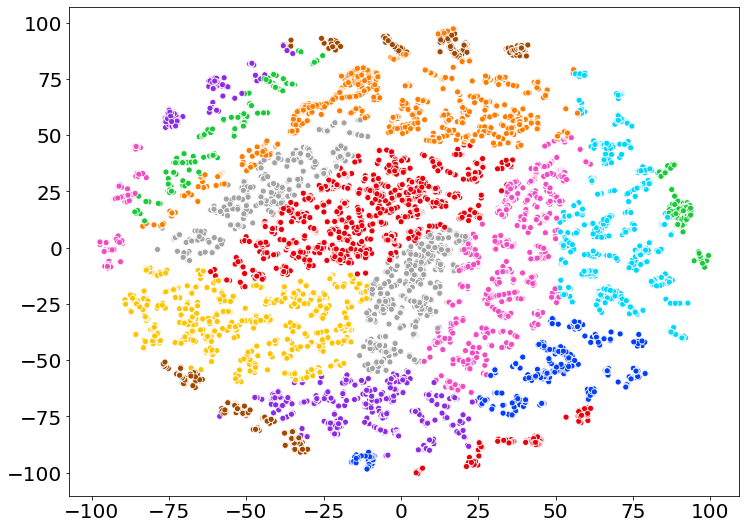

In [19]:
%%time
nb_cluster = nb_devices_for_the_run
print("{0}-tsne".format(filename))
embedded_data = pickle_loader("{0}-tsne".format(filename))
# Finding clusters in the TNSE
predicted_cluster = find_cluster(embedded_data, nb_cluster)
# With the found clusters, splitting data. 
X, Y = clustering_data(data, predicted_cluster, "critical_temp", nb_cluster, scale_Y=True)
dim_notebook = X[0].shape[1] - 1

CPU times: user 22min 20s, sys: 1min 12s, total: 23min 33s
Wall time: 2min 33s


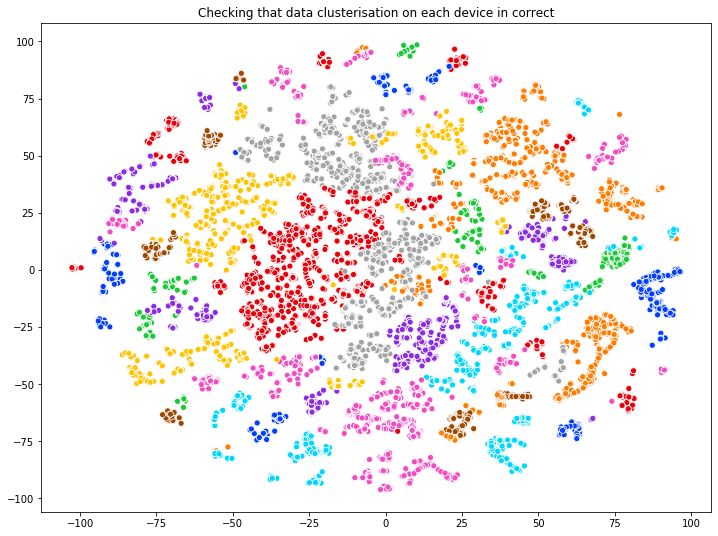

In [20]:
%%time
#Checking that splitting data by cluster is valid.
check_data_clusterisation(X,Y, nb_cluster)

In [21]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [22]:
%%time
obj_min_by_N = {}
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                nb_devices=nb_devices_for_the_run,
                                                nb_epoch=50000, 
                                                quantization_param=0,
                                                momentum = 0., 
                                                verbose=True, 
                                                cost_models=cost_models,
                                                stochastic=False,
                                                bidirectional=False
                                                ))
obj_min_by_N_descent.run(cost_models)
obj_min = obj_min_by_N_descent.losses[-1]

pickle_saver(obj_min, filename + "-noniid-obj_min")

   it    |   obj   
   10000 | 2.4953e-01
   20000 | 2.4604e-01
   30000 | 2.4481e-01
   40000 | 2.4425e-01
Gradient Descent: execution time=1790.238 seconds
Final loss : 0.24395

CPU times: user 5h 24min 16s, sys: 25min 30s, total: 5h 49min 46s
Wall time: 29min 50s


## Batch size $= 1$ (stochastic)

In [23]:
%%time
all_descent = {}
X_number_of_bits = []
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models,
                                               use_averaging=True, stochastic=True,
                                               step_formula=superconduct_step_size,
                                               logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent")

100%|██████████| 5/5 [1:01:24<00:00, 736.92s/it]

CPU times: user 1h 7min 47s, sys: 4min 50s, total: 1h 12min 37s
Wall time: 1h 1min 24s


In [24]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-6.3291e-03,  1.9192e-03,  3.6654e-02,  6.5426e-03,  4.3367e-02,
         4.7248e-02, -7.0579e-02,  1.7507e-01,  3.3695e-01, -5.9372e-02,
         4.5275e-02, -1.4523e-01,  2.9110e-02,  1.8458e-02,  7.4098e-02,
         4.2449e-02,  3.8033e-02,  3.4228e-03,  8.5505e-02,  5.2782e-02,
        -1.2921e-01, -8.0761e-02, -1.1070e-02,  1.7792e-01, -4.7559e-02,
         3.4468e-02,  2.5923e-02,  1.5881e-01,  1.3742e-01, -1.4326e-01,
        -7.3852e-02,  1.7199e-01, -1.2742e-01, -2.9192e-02, -6.8617e-02,
         2.6563e-03, -4.5810e-02, -1.9466e-01, -4.2523e-02,  6.4824e-02,
        -1.9825e-02, -5.1301e-02,  1.2151e-01,  1.1384e-01, -2.3417e-04,
        -2.2722e-01, -1.1835e-01, -1.9694e-01, -1.6371e-01, -1.4801e-01,
         1.4545e-01, -3.4701e-02,  4.8924e-02,  5.2930e-03, -4.5258e-02,
        -3.6273e-02, -1.3837e-02,  1.9425e-01, -5.3129e-02,  1.0678e-01,
         1.2148e-02, -1.0260e-01,  5.5365e-

## Without averaging

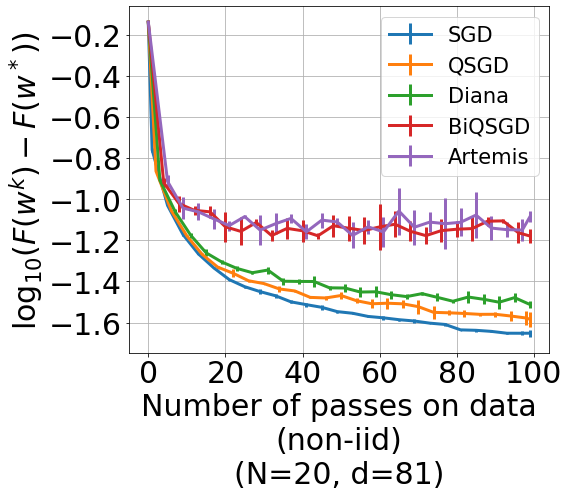

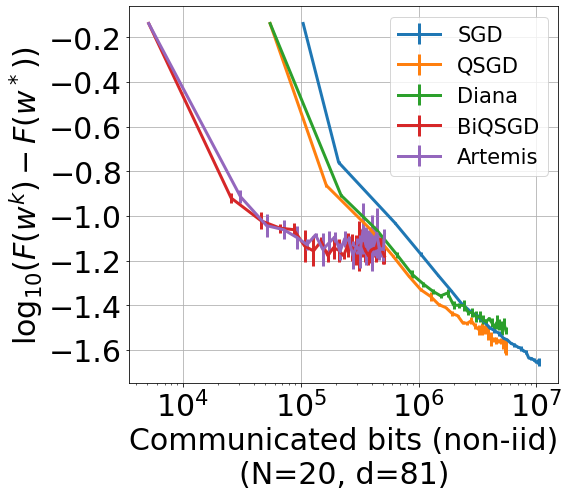

In [25]:
# TEMPORARY - Because the new clusters are different from the ones used to generate the figures.
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

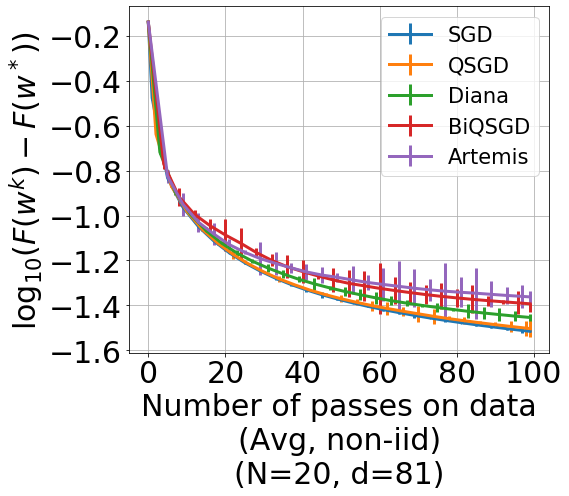

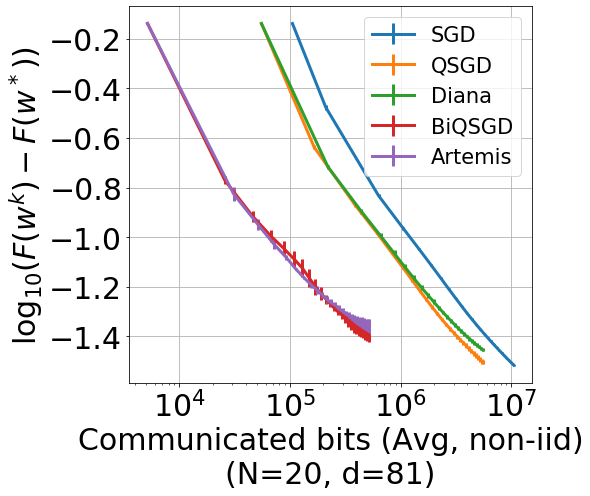

In [26]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader(filename + "-noniid-descent")

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), 
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), 
                x_legend="Communicated bits (Avg, non-iid)") 


## Batch size $= 50$ (stochastic)

In [27]:
%%time
batch_size = 50
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models, 
                                               use_averaging=True, batch_size=batch_size, 
                                               nb_epoch=1000, logs_file="{0}.txt".format(filename))
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, len(X))
pickle_saver(res, filename + "-noniid-descent-{0}".format(batch_size))

100%|██████████| 5/5 [49:29<00:00, 593.99s/it]

CPU times: user 3h 31min 30s, sys: 34min 4s, total: 4h 5min 35s
Wall time: 49min 30s


In [28]:
print("Model obtain from Vanilla SGD descent, the first value corresponds to the bias: ")
print(res.all_final_model[0])

Model obtain from Vanilla SGD descent, the first value corresponds to the bias: 
tensor([-0.0144,  0.0311,  0.0305,  0.0196,  0.0311,  0.0596, -0.0619,  0.1786,
         0.2839, -0.0638,  0.0738, -0.1265,  0.0380,  0.0183,  0.0722,  0.0393,
         0.0219, -0.0033,  0.0562,  0.0346, -0.1024, -0.0726,  0.0049,  0.1448,
        -0.0320,  0.0367,  0.0092,  0.1411,  0.1136, -0.1226, -0.0263,  0.1371,
        -0.1259, -0.0314, -0.0712, -0.0080, -0.0712, -0.1602, -0.0339,  0.0873,
        -0.0288, -0.0632,  0.1005,  0.0777,  0.0003, -0.2045, -0.1139, -0.1976,
        -0.1127, -0.1350,  0.0940, -0.0090,  0.0488, -0.0022, -0.0296, -0.0308,
        -0.0140,  0.1663, -0.0288,  0.0865,  0.0139, -0.1099,  0.0667,  0.2399,
        -0.0507, -0.2217,  0.0942,  0.1212, -0.0064,  0.0247, -0.0260,  0.2039,
         0.0184, -0.0312,  0.0197, -0.0259, -0.0093,  0.0129,  0.0464,  0.1206,
         0.0258, -0.2429], dtype=torch.float64)


## Without averaging

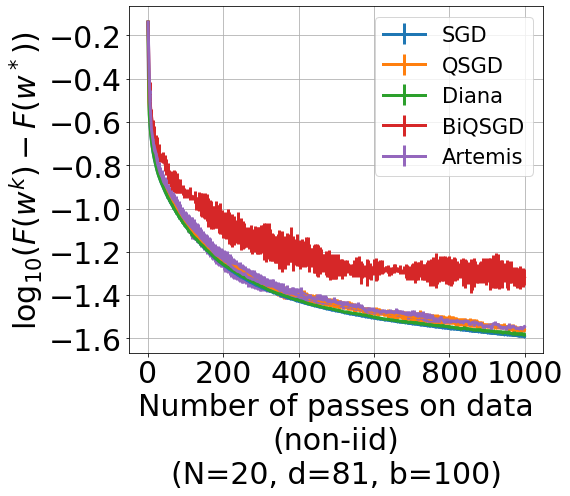

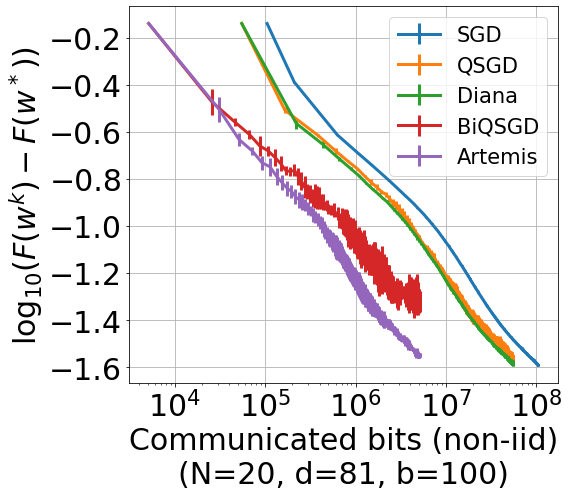

In [29]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, batch_size=batch_size,
                all_error=res.get_std(obj), x_legend="Number of passes on data\n(non-iid)") 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,  batch_size=batch_size,
                x_points=res.X_number_of_bits, x_legend="Communicated bits (non-iid)", all_error=res.get_std(obj)) 

## With averaging

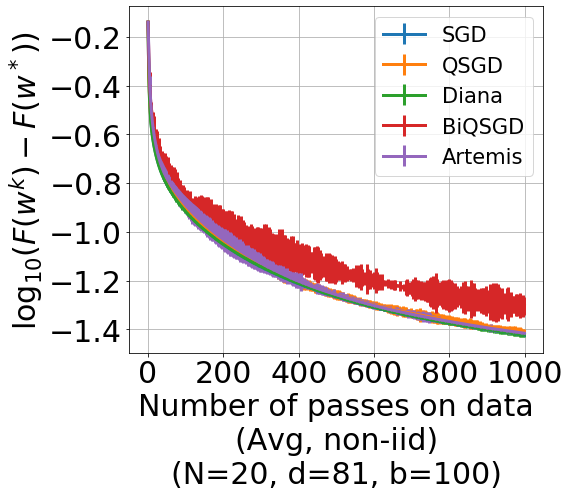

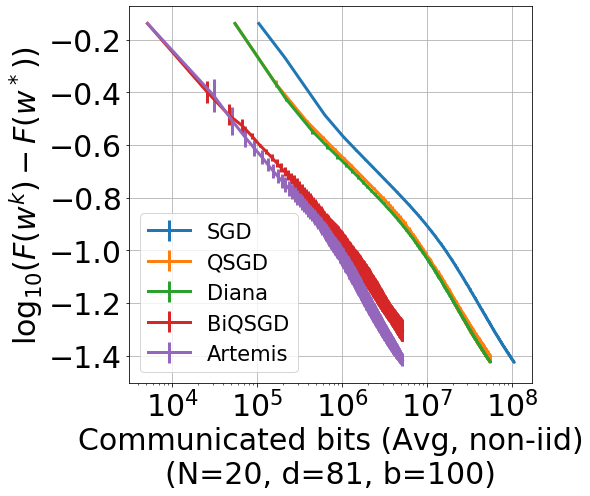

In [30]:
obj = pickle_loader(filename + "-noniid-obj_min")
res = pickle_loader("{0}-noniid-descent-{1}".format(filename, batch_size))

plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, 
                dim_notebook, all_error=res.get_std(obj, averaged=False), batch_size=batch_size,
                x_legend="Number of passes on data\n(Avg, non-iid)") 
plot_error_dist(res.get_loss(obj, averaged=True), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, all_error=res.get_std(obj, averaged=True), batch_size=batch_size,
                x_legend="Communicated bits (Avg, non-iid)") 